In [8]:
%load_ext autoreload
%autoreload 2
import sys

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from IPython.display import Markdown, display
from tqdm.notebook import tqdm

from karateclub.graph_embedding.graph2vec import Graph2Vec
from sklearn.linear_model import LogisticRegression

sys.path.append("../")
from src.graph2vec import OurGraph2Vec, Ensemble_G2V
from src.utils import read_stargazers_dataset,cross_validate, calculate_measure

plt.rcParams["figure.figsize"] = (16, 40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def weighted_mean(alpha: float):
    return lambda x, y: alpha * x + (1 - alpha) * y


def select_by_var(arr: np.array, alpha: float):
    variances_ord = np.var(arr, axis=0).argsort()[::-1]
    return arr[:, variances_ord][:, : int(alpha * arr.shape[1])]


def by_weighted_variance(alpha: float):
    return lambda x, y: np.concatenate(
        (select_by_var(x, alpha), select_by_var(y, 1 - alpha)), axis=1
    )

def project_v_on_w(v,w):
    """
        here x and y are vectors not matrices!!!
    """
    return w*np.vdot(v,w)/np.linalg.norm(w,2)**2

def get_projected_concatenation(vectors,keep_first:bool=True,proj_on_sum:bool=True):
    """
    again applicable if we're having vectors!!!
    """
    x,y=vectors
    v=y if keep_first else x
    proj_w=x+y if proj_on_sum else x if keep_first else y
    return np.concatenate((x+y-v,project_v_on_w(v,proj_w)))

def split(x:np.array):
    half=int(x.size/2)
    return x[:half],x[half:]

def one_by_projection(keep_skipgram:bool=True,proj_on_sum:bool=True):
    return lambda x,y:np.apply_along_axis(lambda z: get_projected_concatenation(split(z),keep_skipgram,proj_on_sum),1,np.concatenate((x,y),axis=1))

def get_differences_of_projections(vectors):
    x,y=vectors
    return np.concatenate((x+y,y-project_v_on_w(y,x+y)))

def projection_diff():
    return lambda x,y:np.apply_along_axis(lambda z: get_differences_of_projections(split(z)),1,np.concatenate((x,y),axis=1))

def get_weighted_projections(vectors,alpha):
    x,y=vectors
    w_m=weighted_mean(alpha)
    vecs_w_sum=w_m(x,y)*2
    return np.concatenate((project_v_on_w(x,vecs_w_sum),project_v_on_w(y,vecs_w_sum)))

def weighted_projections(alpha:float):
    return lambda x,y:np.apply_along_axis(lambda z: get_weighted_projections(split(z),alpha),1,np.concatenate((x,y),axis=1))



In [10]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

order_dict=np.load("../datasets/github_stargazers/orderings.npy",allow_pickle=True)[()]

Loaded 12725 graphs


## Parameters section

In [11]:
subset_card = len(graphs)  # number of graphs

cross_val_k = 26  # number of folds to perform in cross-validation (could be int or LeaveOneOut())

In [12]:
MEASURES=["closeness_centrality","pagerank","current_flow_closeness_centrality"]

tested_range = np.linspace(0, 1, 11)

WEIGHTING_FUNCTIONS = (
    {f"w_mean_{a:.2f}": weighted_mean(a) for a in tested_range}
    | {f"w_var_{a}": by_weighted_variance(a) for a in tested_range}
    | {f"concat": lambda x, y: np.concatenate((x, y), axis=1)}
    | {f"proj_on_{a,b}": one_by_projection(a,b) for a,b in [(True,True),(True,False),(False,True),(False,False)]}
    | {f"proj_and_diff": projection_diff()}
    | {f"w_proj_{a:.2f}": weighted_projections(a) for a in tested_range}
)

## Execution section

In [15]:
graphs_subset = graphs[:subset_card]

without=OurGraph2Vec()
with_dm=OurGraph2Vec(cbowlike=True)
ens_model=Ensemble_G2V(without,with_dm)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

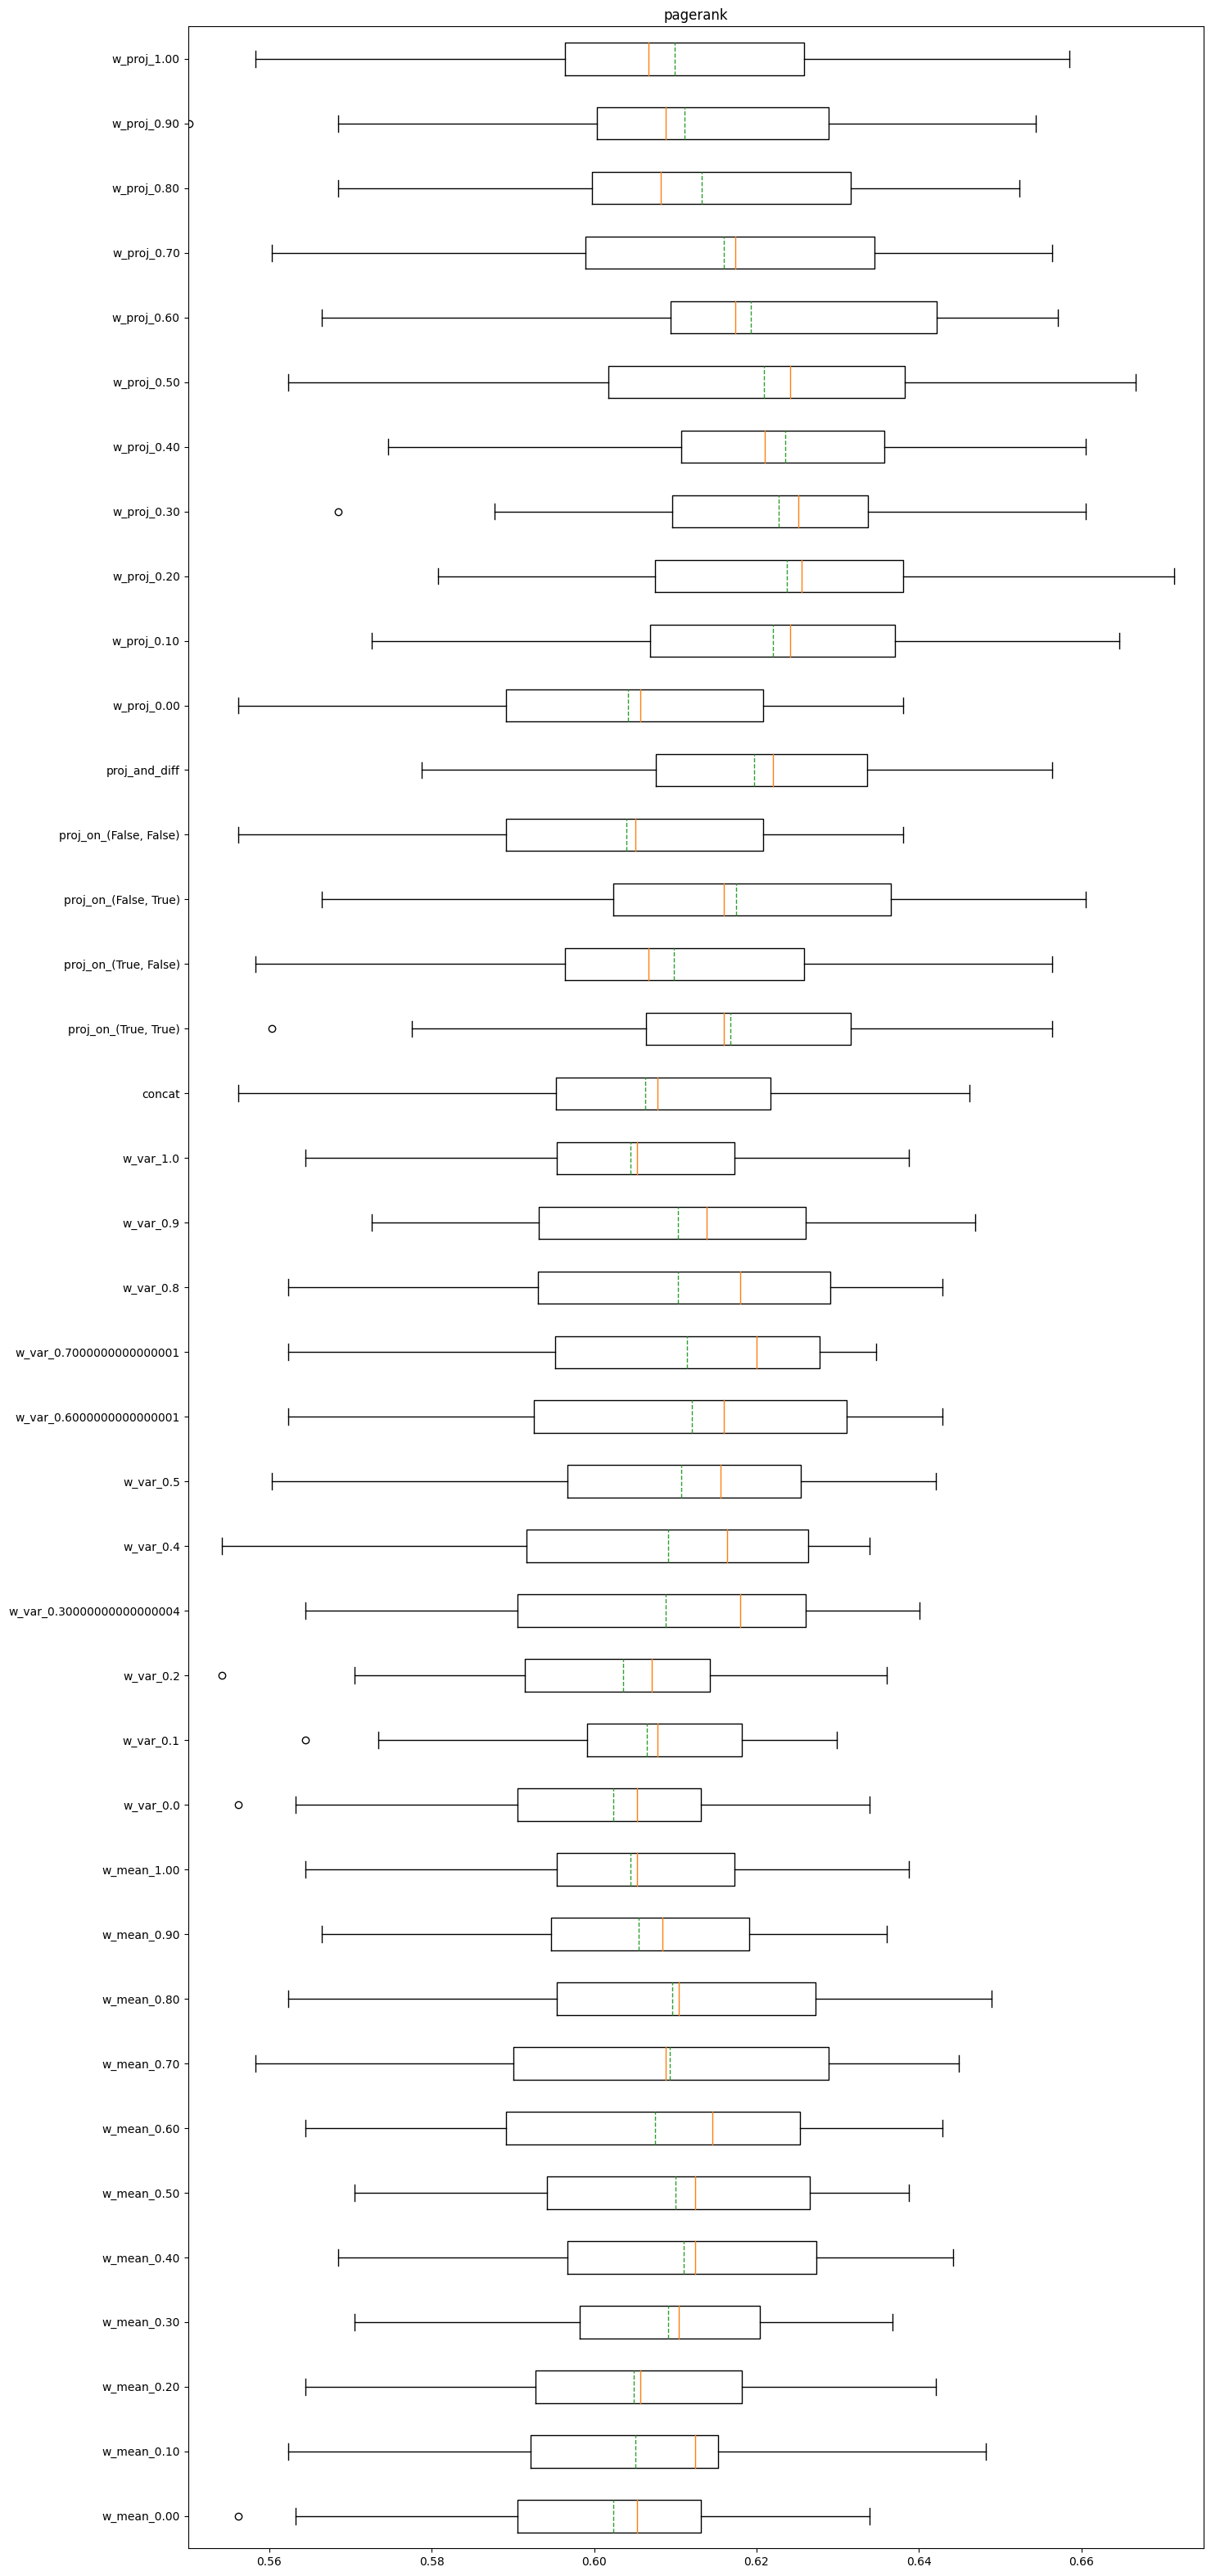

  0%|          | 0/39 [00:00<?, ?it/s]

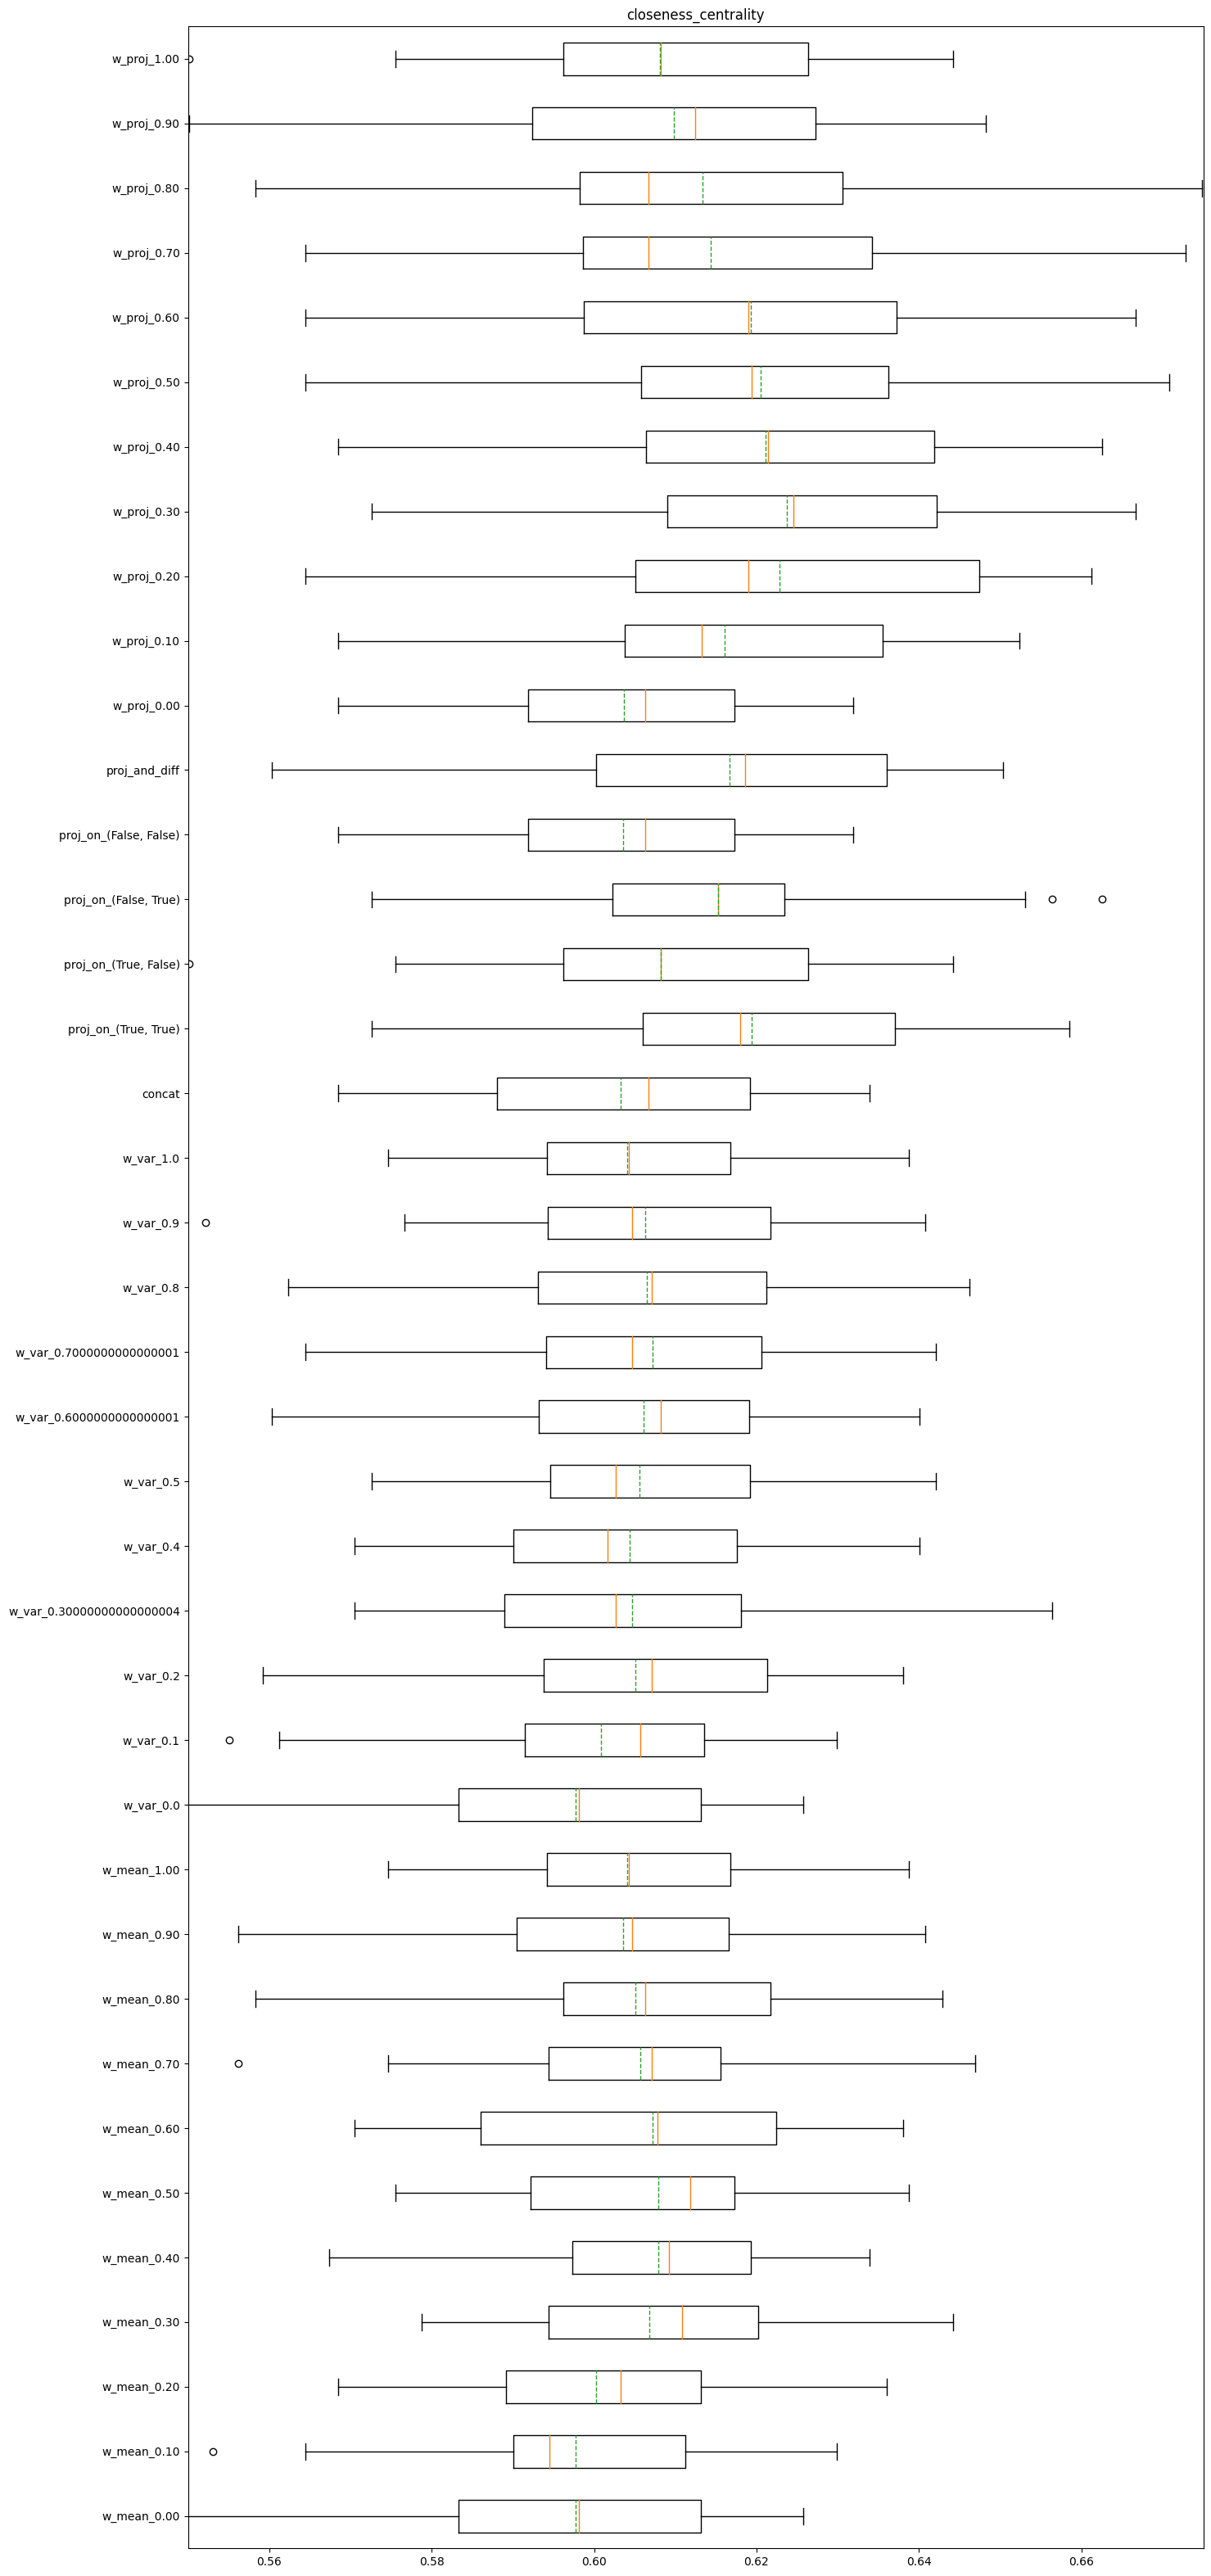

  0%|          | 0/39 [00:00<?, ?it/s]

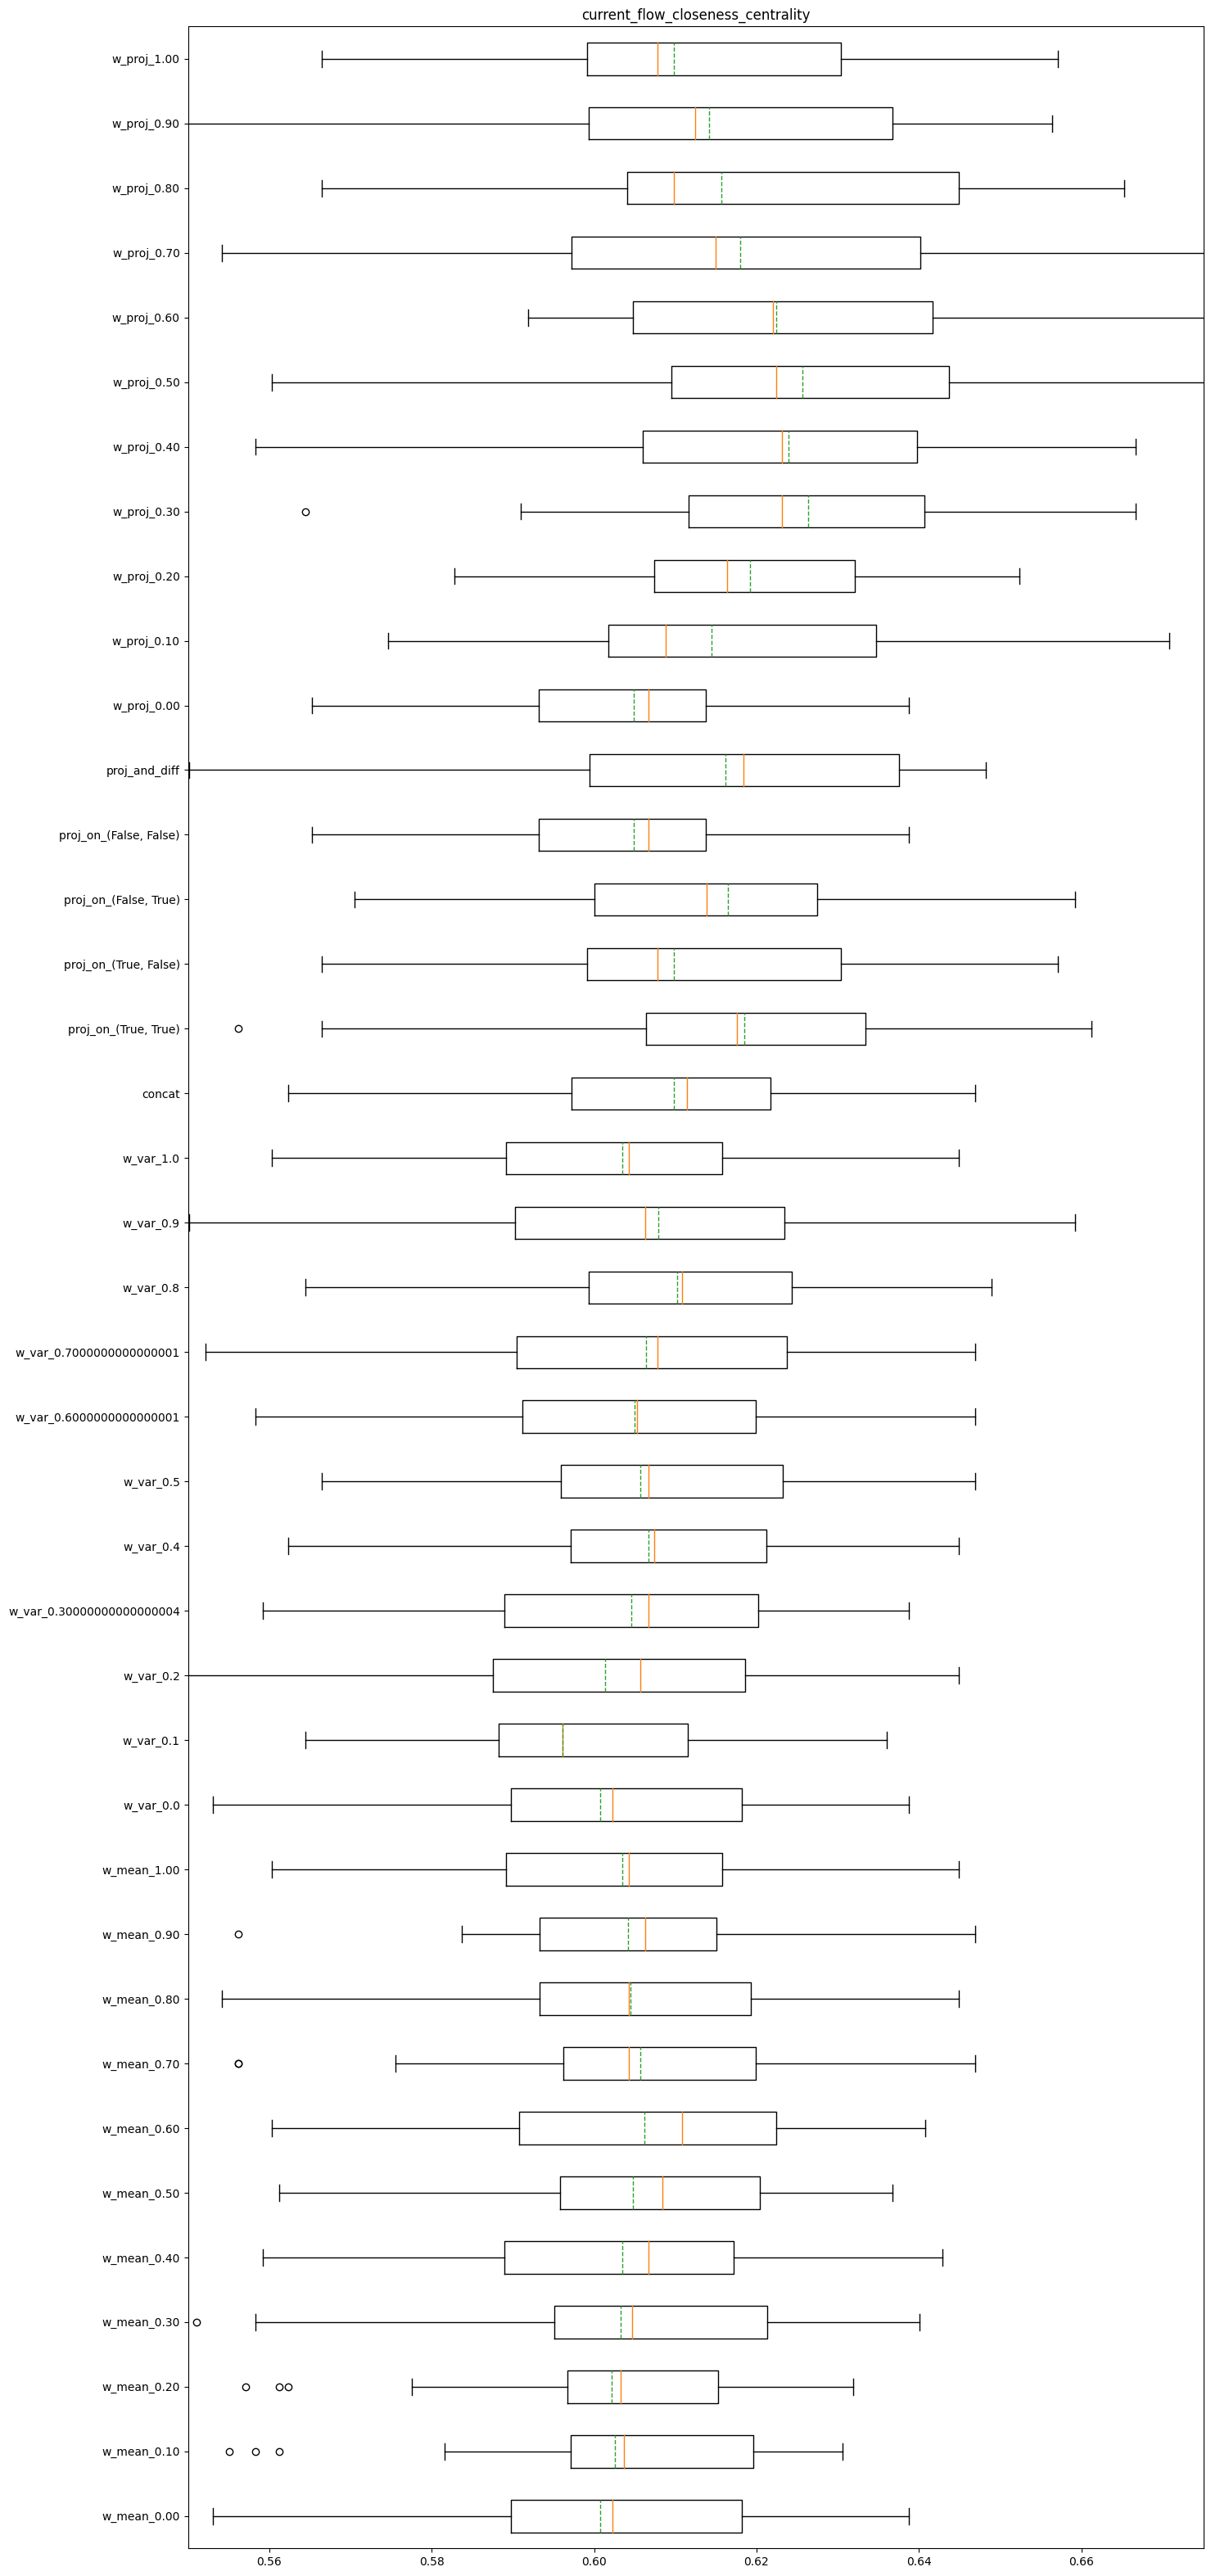

In [16]:
for measure, order in tqdm(order_dict.items()):
    res = {}
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    for name, func in tqdm(WEIGHTING_FUNCTIONS.items(),leave=False):
        ens_model.set_weighting_function(func)
        res[name] = cross_validate(ens_model.get_embedding(), labels,LogisticRegression(max_iter=1000), cv=cross_val_k)
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(res.values(), positions=range(n_items), vert=False, showmeans=True,meanline=True)
    plt.yticks(range(n_items), labels=res.keys())
    plt.xlim([0.55, 0.675])
    plt.show()